In [114]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using SparseArrays
using Plots
include("../fourier_tensor_train.jl")
includet("../bp_fourier.jl");

In [115]:
seed = 4
rng = MersenneTwister(seed)

T = 50
N = 40
c = 3.0
gg = erdos_renyi(N, c/N; seed)
g = IndexedGraph(gg)

β = 1.5
J = 1.0
h = 0.0
m⁰ = 0.2
K = 40

svd_trunc=TruncBond(5)
;

In [116]:
connected_components(gg)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

In [117]:
ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

ising = Ising(g, fill(J,ne(g)), fill(h, nv(g)), β)
bp = Glauber(ising, T; ϕ) |> mpbp

g_ = IndexedBiDiGraph(gg)
w_fourier = [fill(GlauberFactor(fill(J,length(inedges(g,i))), h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g_, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [118]:
iters, cb = iterate!(bp, maxiter=20; svd_trunc);

Running MPBP: iter 2    Time: 0:00:26

Running MPBP: iter 3    Time: 0:00:47

Running MPBP: iter 4    Time: 0:01:05

Running MPBP: iter 5    Time: 0:01:22

Running MPBP: iter 6    Time: 0:01:40

Running MPBP: iter 7    Time: 0:01:57

Running MPBP: iter 8    Time: 0:02:16

Running MPBP: iter 9    Time: 0:02:32

Running MPBP: iter 10    Time: 0:02:49

Running MPBP: iter 11    Time: 0:03:07

Running MPBP: iter 12    Time: 0:03:25

Running MPBP: iter 13    Time: 0:03:42

Running MPBP: iter 14    Time: 0:03:59

Running MPBP: iter 15    Time: 0:04:17

Running MPBP: iter 16    Time: 0:04:35

Running MPBP: iter 17    Time: 0:04:52

Running MPBP: iter 18    Time: 0:05:10

Running MPBP: iter 19    Time: 0:05:26

Running MPBP: iter 20    Time: 0:05:44

In [119]:
iters, cb_fourier = iterate_fourier!(bp_fourier,K, maxiter=30, σ=1/100; svd_trunc, tol=1e-6);

Running MPBP: iter 2    Time: 0:09:32

Running MPBP: iter 3    Time: 0:17:08

Running MPBP: iter 4    Time: 0:25:00

Running MPBP: iter 5    Time: 0:32:49

Running MPBP: iter 6    Time: 0:40:21

Running MPBP: iter 7    Time: 0:47:00

Running MPBP: iter 8    Time: 0:51:15

Running MPBP: iter 9    Time: 0:55:17

Running MPBP: iter 10    Time: 0:59:17

Running MPBP: iter 11    Time: 1:03:18

Running MPBP: iter 12    Time: 1:07:21

Running MPBP: iter 13    Time: 1:11:21

Running MPBP: iter 14    Time: 1:15:20

Running MPBP: iter 15    Time: 1:19:21

Running MPBP: iter 16    Time: 1:23:21

Running MPBP: iter 17    Time: 1:27:21

Running MPBP: iter 18    Time: 1:31:21

Running MPBP: iter 19    Time: 1:35:20

Running MPBP: iter 20    Time: 1:39:18

Running MPBP: iter 21    Time: 1:43:18

Running MPBP: iter 22    Time: 1:47:17

Running MPBP: iter 23    Time: 1:51:15

Running MPBP: iter 24    Time: 1:55:13

Running MPBP: iter 25    Time: 1:59:11

Running MPBP: iter 26    Time: 2:03:09

Running 

In [183]:
potts2spin(x, i; q=2) = (x-1)/(q-1)*2 - 1

i = 30
m = means(potts2spin, bp)[i]
m_fourier = real.(means(potts2spin, bp_fourier))[i]
;

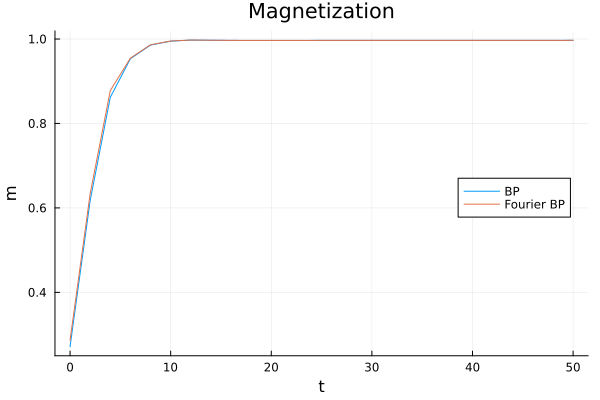

In [184]:
plot(0:2:T, m[1:2:end], label="BP", xlabel="t", ylabel="m", title="Magnetization", legend=:right)
plot!(0:2:T, m_fourier[1:2:end], label="Fourier BP")

In [122]:
using JLD2

m = means(potts2spin, bp)
m_fourier = real.(means(potts2spin, bp_fourier))
jldsave("comparison_beta1,5_J1_er40_magnetization.jld2"; m, m_fourier)

In [123]:
# er_μ = []
# ptr = []
# for e in edges(bp.g)
#     μ_marg = marginalize(bp.μ[idx(e)])
#     margs = marginals(μ_marg)
#     μ_fourier_marg = marginalize(bp_fourier.μ[idx(e)])
#     margs_fourier = marginals(μ_fourier_marg)
#     for t in 1:T+1
#         marg = margs[t]
#         marg_fourier = margs_fourier[t]
#         push!(er_μ, abs(marg_fourier[1]-marg[1]))
#         push!(ptr, (e, t))
#     end
# end

# display(maximum(er_μ))
# display(ptr[argmax(er_μ)])

In [124]:
# er_b = []
# ptr = []
# for i in vertices(bp.g)
#     margs = marginals(bp.b[i])
#     margs_fourier = marginals(bp_fourier.b[i])
#     for t in 1:T+1
#         marg = margs[t]
#         marg_fourier = margs_fourier[t]
#         ind = argmax(abs.(marg))
#         push!(er_b, abs(marg_fourier[ind]-marg[ind]))
#         push!(ptr, (i, t))
#     end
# end

# display(maximum(er_b))
# display(ptr[argmax(er_b)])